In [2]:
import math
import torch
import random
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class CustomMountainCarWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomMountainCarWrapper, self).__init__(env)
        self.prev_state = None

    def step(self, action):
        next_state, _, terminated, truncated, info = self.env.step(action)
        next_state = np.array(next_state, dtype=np.float32)
        
        if self.prev_state is None:
            reward = 0.0
        else:
            prev_energy = math.sin(3 * self.prev_state[0]) * 0.0025 + 0.5 * (self.prev_state[1] ** 2)
            next_energy = math.sin(3 * next_state[0]) * 0.0025 + 0.5 * (next_state[1] ** 2)
            reward = 100 * (next_energy - prev_energy)
        if terminated:
            reward += 100
        self.prev_state = next_state.copy()
        return next_state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        self.prev_state = np.array(state, dtype=np.float32)
        return state, info

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=6):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, env, memory_capacity=20000, batch_size=64,
                 gamma=0.99, lr=0.0005, target_update=90,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.9995):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.policy_net = DQN(input_dim=2, output_dim=self.env.action_space.n).to(self.device)
        self.target_net = DQN(input_dim=2, output_dim=self.env.action_space.n).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(memory_capacity)
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.argmax().item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)
        q_values = self.policy_net(states).gather(1, actions)
        
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        loss = nn.functional.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes=2000, max_steps=200, model_save_path="a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth"):
        rewards_per_episode = []
        epsilon_per_episode = []
        best_reward = float("-inf")

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0

            for t in range(max_steps):
                action = self.select_action(state)
                next_state, _, done, _, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32)
                reward = 100 * ((math.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] ** 2) -
                                (math.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] ** 2))
                next_state = np.array(next_state, dtype=np.float32)
                self.memory.push((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward
                self.optimize_model()
                if done:
                    break

            if episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            epsilon_per_episode.append(self.epsilon)
            rewards_per_episode.append(total_reward)
            if total_reward > best_reward:
                best_reward = total_reward
                self.save_model(model_save_path)
                print(f"Best model: Episode {episode}, Reward: {total_reward}")
            if episode % 100 == 0:
                print(f"Episode {episode}, Total reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
        return rewards_per_episode, epsilon_per_episode

    def save_model(self, filename="a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth"):
        torch.save(self.policy_net.state_dict(), filename)

    def load_model(self, filename="a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth"):
        self.policy_net.load_state_dict(torch.load(filename))
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [4]:
class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.4):
        self.capacity = capacity
        self.buffer = []
        self.priorities = []
        self.pos = 0
        self.alpha = alpha

    def push(self, transition):
        max_priority = max(self.priorities, default=1.0)
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(max_priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = torch.tensor(weights, dtype=torch.float32)

        return samples, indices, weights

    def update_priorities(self, indices, new_priorities):
        for idx, prio in zip(indices, new_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

class PERDQN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=6):
        super(PERDQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class PERDQNAgent:
    def __init__(self, env, memory_capacity=50000, batch_size=64,
                 gamma=0.99, lr=0.0001, target_update=30,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.9995):
        self.env = env
        self.beta_start = 0.4
        self.beta_frames =1000
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.policy_net = PERDQN(input_dim=2, output_dim=self.env.action_space.n).to(self.device)
        self.target_net = PERDQN(input_dim=2, output_dim=self.env.action_space.n).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = PrioritizedReplayMemory(memory_capacity)
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.argmax().item()

    def optimize_model(self, beta=0.4):
        if len(self.memory) < self.batch_size:
            return

        batch, indices, weights = self.memory.sample(self.batch_size, beta=beta)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)
        weights = weights.unsqueeze(1).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)
        next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.target_net(next_states).gather(1, next_actions).detach()
        targets = rewards + self.gamma * next_q_values * (~dones)

        td_errors = q_values - targets
        loss = (weights * td_errors.pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        new_priorities = td_errors.abs().detach().cpu().squeeze().numpy().tolist()
        self.memory.update_priorities(indices, new_priorities)


    def train(self, num_episodes=2000, max_steps=200, model_save_path="a2_part_3_perdqn_mountaincar_shrutili_omjagatr.pth"):
        rewards_per_episode = []
        epsilon_per_episode = []
        best_reward = float("-inf")

        for episode in range(num_episodes):
            beta = min(1.0, self.beta_start + episode / self.beta_frames)
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0

            for t in range(max_steps):
                action = self.select_action(state)
                next_state, _, done, _, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32)
                reward = 100 * ((math.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] ** 2) -
                                (math.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] ** 2))
                next_state = np.array(next_state, dtype=np.float32)
                self.memory.push((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward
                self.optimize_model(beta=beta)
                if done:
                    break

            if episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            epsilon_per_episode.append(self.epsilon)
            rewards_per_episode.append(total_reward)
            if total_reward > best_reward:
                best_reward = total_reward
                self.save_model(model_save_path)
                print(f"Best model: Episode {episode}, Reward: {total_reward}")
            if episode % 100 == 0:
                print(f"Episode {episode}, Total reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
        return rewards_per_episode, epsilon_per_episode

    def save_model(self, filename="a2_part_3_perdqn_mountaincar_shrutili_omjagatr.pth"):
        torch.save(self.policy_net.state_dict(), filename)

    def load_model(self, filename="a2_part_3_perdqn_mountaincar_shrutili_omjagatr.pth"):
        self.policy_net.load_state_dict(torch.load(filename))
        self.target_net.load_state_dict(self.policy_net.state_dict())

> Training DQN Agent

In [ ]:
env = gym.make("MountainCar-v0", render_mode="human")
env = CustomMountainCarWrapper(env)
dqn_agent = DQNAgent(env)
rewards, epsilons = dqn_agent.train(num_episodes=2000, model_save_path="a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth")

2025-04-03 14:26:56.739 Python[8538:92215] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-03 14:26:56.739 Python[8538:92215] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Best model: Episode 0, Reward: 0.0036705518141388893
Episode 0, Total reward: 0.0036705518141388893, Epsilon: 1.000
Best model: Episode 1, Reward: 0.029244206845760345
Best model: Episode 26, Reward: 0.07039155066013336
Best model: Episode 36, Reward: 0.09347938746213913
Best model: Episode 77, Reward: 0.13368606567382812
Episode 100, Total reward: 0.026364818215370178, Epsilon: 0.951
Best model: Episode 123, Reward: 0.16975052654743195
Episode 200, Total reward: 0.024557583034038544, Epsilon: 0.904
Best model: Episode 220, Reward: 0.22304855287075043
Best model: Episode 266, Reward: 0.23890584707260132
Episode 300, Total reward: 0.0417649932205677, Epsilon: 0.860
Best model: Episode 335, Reward: 0.25086507201194763
Best model: Episode 390, Reward: 0.3216393291950226
Episode 400, Total reward: 0.05832831561565399, Epsilon: 0.818
Episode 500, Total reward: 0.24542777240276337, Epsilon: 0.778
Best model: Episode 572, Reward: 0.32443663477897644
Best model: Episode 574, Reward: 0.33753731

> Total Rewards per Episode

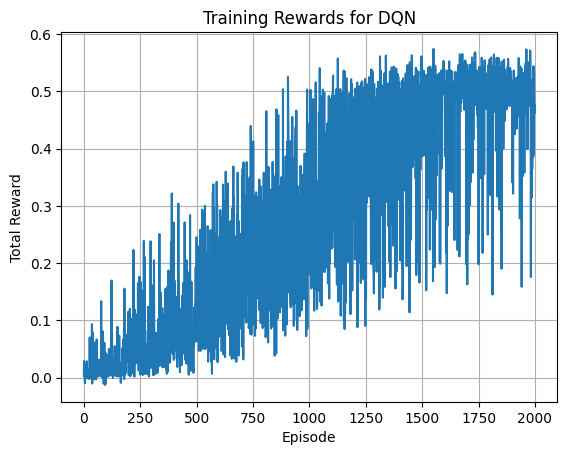

In [6]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards for DQN")
plt.grid(True)
plt.show()

> Epsilon Decay Graph

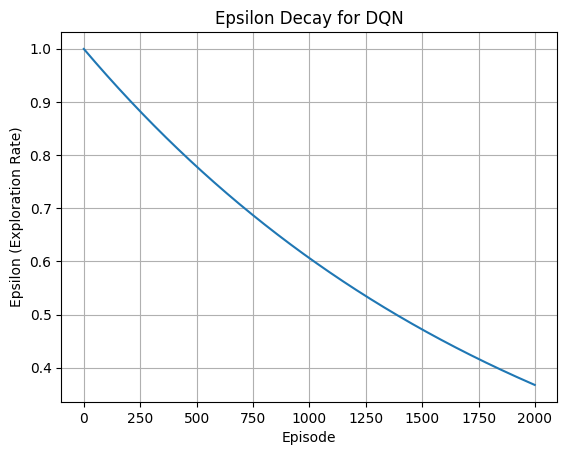

In [7]:
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon (Exploration Rate)")
plt.title("Epsilon Decay for DQN")
plt.grid(True)
plt.show()

> Running the agent for 10 episodes, where
the agent chooses only greedy actions from the learnt policy.

In [ ]:
env = gym.make("MountainCar-v0", render_mode="human")
dqn_agent = DQNAgent(env)
dqn_agent.load_model("a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth")

eval_rewards = []
for episode in range(10):
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32)
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(dqn_agent.device)
            action = dqn_agent.policy_net(state_tensor).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = np.array(next_state, dtype=np.float32)
        total_reward += reward
        done = terminated or truncated

    eval_rewards.append(total_reward)
    print(f"Episode {episode+1}, Total Reward: {total_reward}")
env.close()

2025-04-03 22:14:52.770 Python[12978:299680] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-03 22:14:52.771 Python[12978:299680] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Episode 1, Total Reward: -124.0
Episode 2, Total Reward: -124.0
Episode 3, Total Reward: -181.0
Episode 4, Total Reward: -124.0
Episode 5, Total Reward: -200.0
Episode 6, Total Reward: -124.0
Episode 7, Total Reward: -125.0
Episode 8, Total Reward: -123.0
Episode 9, Total Reward: -200.0
Episode 10, Total Reward: -123.0


> Total Reward per Episode for Evaluation

/var/folders/c5/l_rlzbnd5b5bsdf_zp23bj5m0000gn/T/ipykernel_12978/2399744707.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


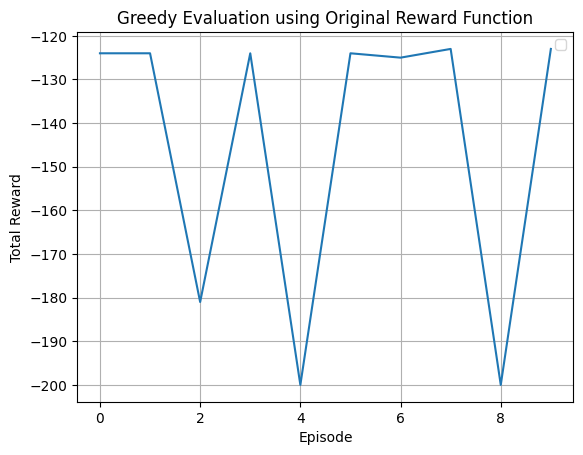

In [6]:
plt.plot(eval_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Greedy Evaluation using Original Reward Function")
plt.legend()
plt.grid(True)
plt.show()

> 1 episode where the agent chooses only
greedy actions from the learned policy

In [ ]:
env = gym.make("MountainCar-v0", render_mode="human")
dqn_agent = DQNAgent(env)
dqn_agent.load_model("a2_part_2_dqn_mountaincar_shrutili_omjagatr.pth")
state, _ = env.reset()
state = np.array(state, dtype=np.float32)
total_reward = 0
done = False
step = 0

while not done:
    env.render()
            
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(dqn_agent.device)
    with torch.no_grad():
        action = dqn_agent.policy_net(state_tensor).argmax().item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = np.array(next_state, dtype=np.float32)
    print(f"Step {step}: State = {np.round(state, 4)}, Action = {action}, Reward = {reward:.2f}")
    total_reward += reward
    state = next_state
    done = terminated or truncated
    step += 1
env.close()
print(f"Greedy episode total reward: {total_reward}")

Step 0: State = [-0.5327  0.    ], Action = 2, Reward = -1.00
Step 1: State = [-0.5317  0.0011], Action = 2, Reward = -1.00
Step 2: State = [-0.5295  0.0021], Action = 2, Reward = -1.00
Step 3: State = [-0.5264  0.0032], Action = 2, Reward = -1.00
Step 4: State = [-0.5222  0.0042], Action = 2, Reward = -1.00
Step 5: State = [-0.517   0.0052], Action = 2, Reward = -1.00
Step 6: State = [-0.5109  0.0061], Action = 2, Reward = -1.00
Step 7: State = [-0.5038  0.007 ], Action = 2, Reward = -1.00
Step 8: State = [-0.4959  0.0079], Action = 2, Reward = -1.00
Step 9: State = [-0.4872  0.0087], Action = 2, Reward = -1.00
Step 10: State = [-0.4778  0.0094], Action = 2, Reward = -1.00
Step 11: State = [-0.4678  0.0101], Action = 2, Reward = -1.00
Step 12: State = [-0.4571  0.0107], Action = 2, Reward = -1.00
Step 13: State = [-0.446   0.0112], Action = 2, Reward = -1.00
Step 14: State = [-0.4344  0.0116], Action = 2, Reward = -1.00
Step 15: State = [-0.4225  0.0119], Action = 2, Reward = -1.00
St

> Training DQN with PER

In [8]:
env = gym.make("MountainCar-v0", render_mode="human")
env = CustomMountainCarWrapper(env)
perdqn_agent = PERDQNAgent(env)
per_rewards, per_epsilons = perdqn_agent.train(num_episodes=2000, model_save_path="a2_part_3_perdqn_mountaincar_shrutili_omjagatr.pth")

/var/folders/c5/l_rlzbnd5b5bsdf_zp23bj5m0000gn/T/ipykernel_8538/3925520760.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.tensor(states, dtype=torch.float32, device=self.device)


Best model: Episode 0, Reward: 0.0016197096556425095
Episode 0, Total reward: 0.0016197096556425095, Epsilon: 1.000
Best model: Episode 1, Reward: 0.015787020325660706
Best model: Episode 17, Reward: 0.020197967067360878
Best model: Episode 22, Reward: 0.07004912197589874
Best model: Episode 31, Reward: 0.08907808363437653
Episode 100, Total reward: -0.0026917550712823868, Epsilon: 0.951
Best model: Episode 119, Reward: 0.10370761901140213
Best model: Episode 144, Reward: 0.11231791973114014
Episode 200, Total reward: 0.051245421171188354, Epsilon: 0.904
Best model: Episode 210, Reward: 0.16355887055397034
Best model: Episode 260, Reward: 0.1950637251138687
Episode 300, Total reward: 0.028417356312274933, Epsilon: 0.860
Best model: Episode 308, Reward: 0.25036942958831787
Best model: Episode 358, Reward: 0.29119136929512024
Best model: Episode 394, Reward: 0.3228253126144409
Episode 400, Total reward: 0.05001828446984291, Epsilon: 0.818
Episode 500, Total reward: 0.025026608258485794, 

> Total Rewards per Episode

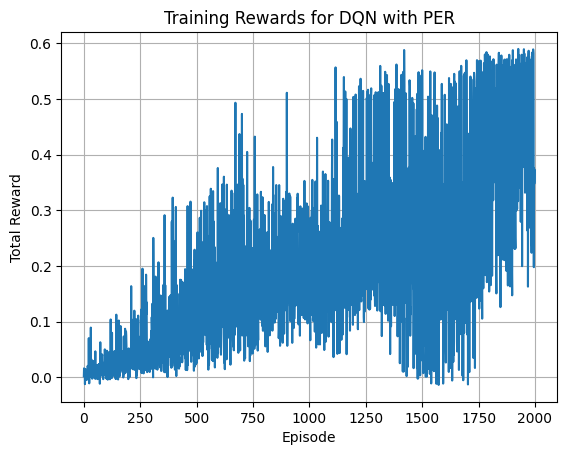

In [14]:
plt.plot(per_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards for DQN with PER")
plt.grid(True)
plt.show()

> Epsilon Decay Graph

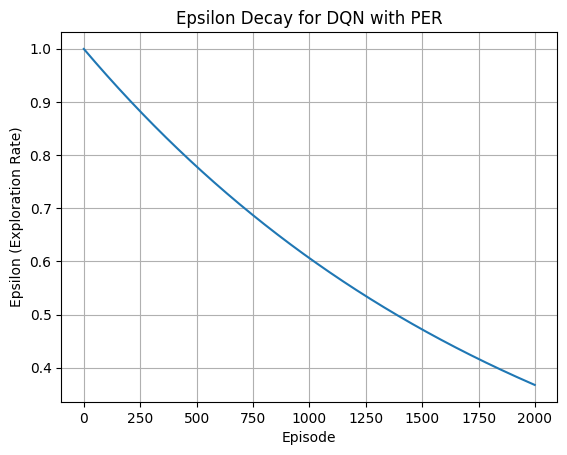

In [15]:
plt.plot(per_epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon (Exploration Rate)")
plt.title("Epsilon Decay for DQN with PER")
plt.grid(True)
plt.show()

> Comparison Plots

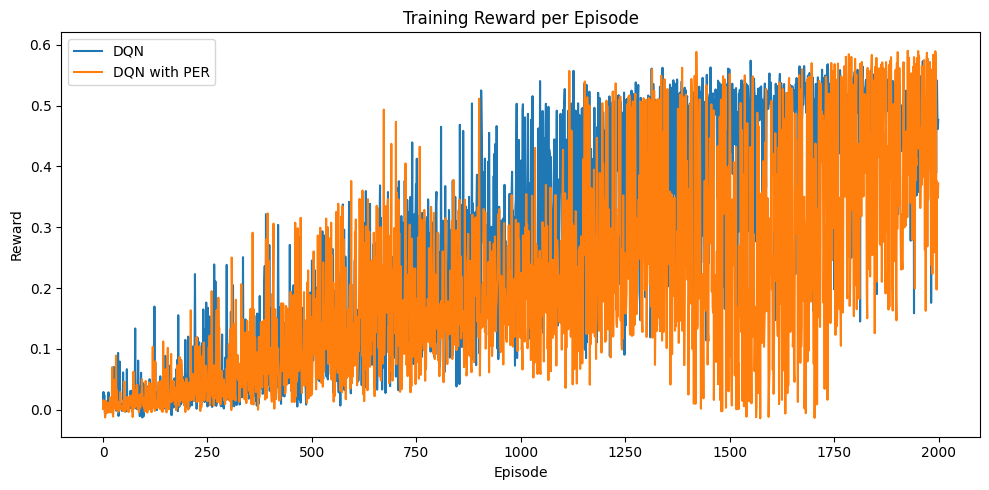

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(rewards, label='DQN')
plt.plot(per_rewards, label='DQN with PER')
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.tight_layout()
plt.show()

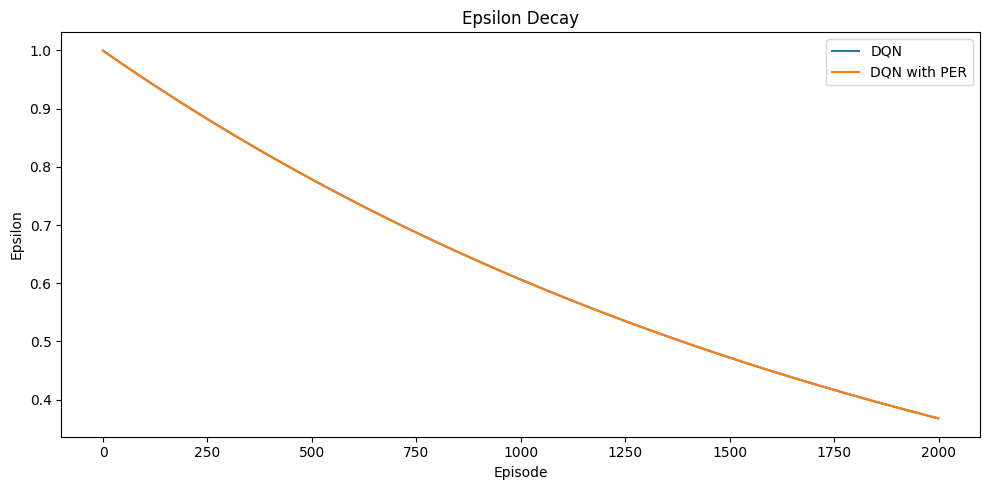

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(epsilons, label='DQN')
plt.plot(per_epsilons, label='DQN with PER')
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.tight_layout()
plt.show()

> Running the agent for 10 episodes, where
the agent chooses only greedy actions from the learnt policy.

In [28]:
env = gym.make("MountainCar-v0", render_mode="human")
perdqn_agent.load_model("a2_part_3_perdqn_mountaincar_shrutili_omjagatr.pth")

evaluation_rewards = []
for episode in range(10):
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32)
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(perdqn_agent.device)
            action = perdqn_agent.policy_net(state_tensor).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = np.array(next_state, dtype=np.float32)
        total_reward += reward
        done = terminated or truncated

    evaluation_rewards.append(total_reward)
    print(f"Episode {episode+1}, Total Reward: {total_reward}")
env.close()

Episode 1, Total Reward: -115.0
Episode 2, Total Reward: -200.0
Episode 3, Total Reward: -118.0
Episode 4, Total Reward: -200.0
Episode 5, Total Reward: -200.0
Episode 6, Total Reward: -200.0
Episode 7, Total Reward: -200.0
Episode 8, Total Reward: -117.0
Episode 9, Total Reward: -117.0
Episode 10, Total Reward: -118.0


> Total Reward per Episode for Evaluation

/var/folders/c5/l_rlzbnd5b5bsdf_zp23bj5m0000gn/T/ipykernel_8538/3316343013.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


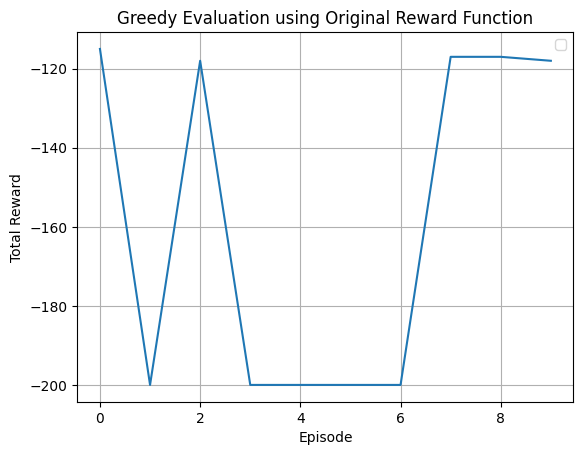

In [29]:
plt.plot(evaluation_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Greedy Evaluation using Original Reward Function")
plt.legend()
plt.grid(True)
plt.show()

> 1 episode where the agent chooses only
greedy actions from the learned policy

In [26]:
env = gym.make("MountainCar-v0", render_mode="human")
perdqn_agent.load_model("a2_part_3_perdqn_mountaincar_shrutili_omjagatr.pth")
state, _ = env.reset()
state = np.array(state, dtype=np.float32)
total_reward = 0
done = False
step = 0

while not done:
    env.render()
            
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(perdqn_agent.device)
    with torch.no_grad():
        action = perdqn_agent.policy_net(state_tensor).argmax().item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = np.array(next_state, dtype=np.float32)
    print(f"Step {step}: State = {np.round(state, 4)}, Action = {action}, Reward = {reward:.2f}")
    total_reward += reward
    state = next_state
    done = terminated or truncated
    step += 1
env.close()
print(f"Greedy episode total reward: {total_reward}")

Step 0: State = [-0.5846  0.    ], Action = 2, Reward = -1.00
Step 1: State = [-0.5831  0.0015], Action = 2, Reward = -1.00
Step 2: State = [-0.5802  0.0029], Action = 2, Reward = -1.00
Step 3: State = [-0.5759  0.0043], Action = 2, Reward = -1.00
Step 4: State = [-0.5702  0.0057], Action = 2, Reward = -1.00
Step 5: State = [-0.5631  0.0071], Action = 2, Reward = -1.00
Step 6: State = [-0.5548  0.0084], Action = 2, Reward = -1.00
Step 7: State = [-0.5452  0.0096], Action = 2, Reward = -1.00
Step 8: State = [-0.5344  0.0108], Action = 2, Reward = -1.00
Step 9: State = [-0.5226  0.0118], Action = 2, Reward = -1.00
Step 10: State = [-0.5098  0.0128], Action = 2, Reward = -1.00
Step 11: State = [-0.4961  0.0137], Action = 2, Reward = -1.00
Step 12: State = [-0.4815  0.0145], Action = 2, Reward = -1.00
Step 13: State = [-0.4663  0.0152], Action = 2, Reward = -1.00
Step 14: State = [-0.4506  0.0158], Action = 2, Reward = -1.00
Step 15: State = [-0.4343  0.0162], Action = 2, Reward = -1.00
St